## Drug spectra Data Camp : clasification and regression tasks ##

In [1]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sc

from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import accuracy_score

In [2]:
train_filename = 'train.csv'
target_column_name_clf = 'molecule'
target_column_name_reg = 'concentration'

labels = np.array(['A', 'B', 'Q', 'R'])

def read_data(filename):
    df = pd.read_csv(filename)
    y_df = df[[target_column_name_clf, target_column_name_reg]]
    X_df = df.drop([target_column_name_clf, target_column_name_reg], axis=1)
    spectra = X_df['spectra'].values
    spectra = np.array(
        [np.array(dd[1:-1].split(',')).astype(float) for dd in spectra])
    X_df['spectra'] = spectra.tolist()
    return X_df, y_df

In [3]:
X_df, y_df = read_data(train_filename)

skf = ShuffleSplit(n_splits=1, test_size=0.2, random_state=57)

for train_is, test_is in skf.split(y_df):
    X_train_df = X_df.iloc[train_is].copy()
    y_train_df = y_df.iloc[train_is].copy()
    X_test_df = X_df.iloc[test_is].copy()
    y_test_df = y_df.iloc[test_is].copy()

In [4]:
y_train_clf = y_train_df['molecule'].values
y_test_clf = y_test_df['molecule'].values

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA, KernelPCA, IncrementalPCA
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator
from sklearn.svm import SVC 
from sklearn.model_selection import GridSearchCV

class Classifier(BaseEstimator):
    def __init__(self):
        
        self.n_components = 10 # Arack as eigen_solver then, because n_components much smaller than number_samples
        self.n_estimators = 300

    def fit(self, X, y, C):
        self.clf = Pipeline([
            ('kpca', KernelPCA(n_components=self.n_components, fit_inverse_transform=True, eigen_solver='arpack')),
            ('svc', SVC(C, probability=True))
        ])
        self.clf.fit(X, y)

    def predict(self, X):
        return self.clf.predict(X)

    def predict_proba(self, X, surestimate):
        prediction = self.clf.predict_proba(X)
        prediction[:,1] *= surestimate # Error on B predominant over the rest
        return prediction

The KPCA is useful in our case to project the data in a space that make possible to separate them linearly.
The idea here is to drastically decrease the number of components for the KPCA.
It can be explained by the fact that we are keeping only fiew intensities from each spectra : the ones with the hightest variance.
Furthermore, we use arpack as eigensolver because the compononents number is much smaller than the number of samples

A chose the SVC over the random forest classifier by testing, and set the probability mode to true.

error = 0.015


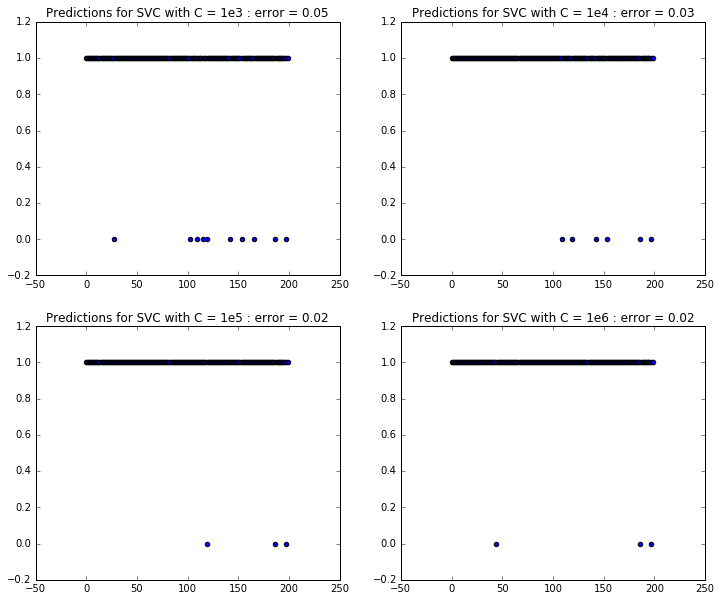

In [6]:
X_train_array_clf = np.array([np.array(dd) for dd in X_train_df['spectra']])
X_test_array_clf = np.array([np.array(dd) for dd in X_test_df['spectra']])

"""fe_clf = feature_extractor_clf.FeatureExtractorClf()
X_train_array_clf = fe_clf.transform(X_train_df)
X_test_array_clf = fe_clf.transform(X_test_df)"""

clf = Classifier()
plt.rcParams['figure.figsize'] = (12.0, 10.0)
for i in range(4):
    plt.subplot(2, 2, i+1)
    clf.fit(X_train_array_clf, y_train_clf, C=10 ** (i+4))
    y_proba_clf = clf.predict_proba(X_test_array_clf, 1.42)
    y_pred_clf = labels[np.argmax(y_proba_clf, axis=1)]
    plt.scatter(np.arange(len(y_pred_clf)), y_pred_clf==y_test_clf)
    plt.title('Predictions for SVC with C = 1e%d : error = %.2f' % (int(i+3), 1 - accuracy_score(y_test_clf, y_pred_clf)), fontsize = 12)

error = 1 - accuracy_score(y_test_clf, y_pred_clf)
print('error = %s' % error)

We note here that a huge value of C as penalization for the support vector algorithm decreases the errors.
Furthermore, we observe there are not located at a specific area.
I will try to determine which errors are predominant.

In [7]:
for i in range(len(y_test_clf)):
    if y_test_clf[i] != y_pred_clf[i]:
        print("Prediction: " + y_test_clf[i] + "\tTrue label: " + y_pred_clf[i])

Prediction: A	True label: B
Prediction: A	True label: B
Prediction: A	True label: B


Let's note here that many errors are based on the molecule B, the next idea is to surestimate the probability associated to B:

In [8]:
skf = ShuffleSplit(n_splits=10, test_size=0.2, random_state=57)
compt = 0
errorsum1 = 0
errorsum2 = 0

for train_is, test_is in skf.split(y_df):
    compt += 1
    X_train_df = X_df.iloc[train_is].copy()
    y_train_df = y_df.iloc[train_is].copy()
    X_test_df = X_df.iloc[test_is].copy()
    y_test_df = y_df.iloc[test_is].copy()
    
    y_train_clf = y_train_df['molecule'].values
    y_test_clf = y_test_df['molecule'].values
    
    X_train_array_clf = np.array([np.array(dd) for dd in X_train_df['spectra']])
    X_test_array_clf = np.array([np.array(dd) for dd in X_test_df['spectra']])

    for i in range(2):
        clf.fit(X_train_array_clf, y_train_clf, C=10 ** 5)
        if i==0:
            y_proba_clf = clf.predict_proba(X_test_array_clf, 1)
        else:
            y_proba_clf = clf.predict_proba(X_test_array_clf, 1.42)
        y_pred_clf = labels[np.argmax(y_proba_clf, axis=1)]
        if i == 0:
            error1 = 1 - accuracy_score(y_test_clf, y_pred_clf)
            errorsum1 += error1
        else:
            error2 = 1 - accuracy_score(y_test_clf, y_pred_clf)
            errorsum2 += error2
        
print('Error without surestimation = ', errorsum1/compt)
print('Error with surestimation = ', errorsum2/compt)

Error without surestimation =  0.043
Error with surestimation =  0.0385


We see here that, as a average score for 10 splits on the model validation, the error is smaller when we surestimate the probabilities for B.

**Regression**

I that the vial and solute features were pointless both for classification and for regression. This way I was able to eliminate these features from any later reasoning. 

In [9]:
labels = np.array(['A', 'B', 'Q', 'R'])

class FeatureExtractorReg():
    def __init__(self):
        pass

    def fit(self, X_df, y):
        pass

    def transform(self, X_df):
        XX = np.array([np.array(dd) for dd in X_df['spectra']])
        
        XX_max = np.max(XX, axis=1)
        
        XX -= np.mean(XX, axis=1)[:, None]
        XX /= np.sqrt(np.sum(XX ** 2, axis=1))[:, None]
        
        XX = np.c_[XX, XX_max, X_df[labels].values]
        
        return XX


In [10]:
from sklearn.ensemble import GradientBoostingRegressor 
from sklearn.pipeline import Pipeline                                            
from sklearn.base import BaseEstimator
  
concentration = {'A': [300, 400, 600, 800, 1000, 1400, 1600, 2000, 5000, 10000],
                 'B': [500, 1000, 1500, 2000, 4000, 5000, 7000, 10000, 20000, 25000],
                 'Q': [1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000],
                 'R': [400, 800, 1000, 1200, 1600, 2000, 3000, 4000, 5000, 10000]
                }
                                              
class Regressor(BaseEstimator):                          
    def __init__(self):                                                          
        self.n_components = 9
        self.n_estimators = 1500
        self.learning_rate = 0.2                                            
        self.list_molecule = ['A', 'B', 'Q', 'R']                      
        self.dict_reg = {}                                                       
        for mol in self.list_molecule:                                           
            self.dict_reg[mol] = Pipeline([
                ('kpca', KernelPCA(n_components=self.n_components, fit_inverse_transform=True, eigen_solver='arpack')),                
                ('reg', GradientBoostingRegressor(loss='huber', learning_rate=0.02, n_estimators=self.n_estimators, subsample=0.35, random_state=42, alpha=0.95))
            ])                                                                   
                                                                                 
    def fit(self, X, y):                                                         
        for i, mol in enumerate(self.list_molecule):                             
            ind_mol = np.where(np.argmax(X[:, -4:], axis=1) == i)[0]             
            XX_mol = X[ind_mol]                                                  
            y_mol = y[ind_mol].astype(float)                                
            self.dict_reg[mol].fit(XX_mol, np.log(y_mol))                        
                                                                                 
    def predict(self, X):
        y_pred = np.zeros(X.shape[0])                                            
        for i, mol in enumerate(self.list_molecule):                             
            ind_mol = np.where(np.argmax(X[:, -4:], axis=1) == i)[0]             
            XX_mol = X[ind_mol].astype(float)                                    
            y_pred[ind_mol] = np.exp(self.dict_reg[mol].predict(XX_mol))
                        
            vector_concentration = np.zeros(y_pred[ind_mol].shape) 
            for j, predict_conc in enumerate(y_pred[ind_mol]):
                indice = np.argmin(np.abs(np.ones(len(concentration[mol]))*predict_conc - np.asarray(concentration[mol])))
                vector_concentration[j] = concentration[mol][indice]

            y_pred[ind_mol] = vector_concentration
            
        return y_pred

In [11]:
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import accuracy_score

np.set_printoptions(threshold=np.nan)
train_filename = 'train.csv'
target_column_name_clf = 'molecule'
target_column_name_reg = 'concentration'

labels = np.array(['A', 'B', 'Q', 'R'])


def mare_score(y_true, y_pred):       
    return np.mean(np.abs((y_true - y_pred) / y_true))


def read_data(filename):
    df = pd.read_csv(filename)
    y_df = df[[target_column_name_clf, target_column_name_reg]]
    X_df = df.drop([target_column_name_clf, target_column_name_reg], axis=1)
    spectra = X_df['spectra'].values
    spectra = np.array(
        [np.array(dd[1:-1].split(',')).astype(float) for dd in spectra])
    X_df['spectra'] = spectra.tolist()
    return X_df, y_df

if __name__ == '__main__':
    maremoy = 0
    cpt = 0
    print("Reading file ...")
    X_df, y_df = read_data(train_filename)
    skf = ShuffleSplit(n_splits=10, test_size=0.2, random_state=57)
    print("Training file ...")
    for train_is, test_is in skf.split(y_df):
        print('--------------------------')
        X_train_df = X_df.iloc[train_is].copy()
        y_train_df = y_df.iloc[train_is].copy()
        X_test_df = X_df.iloc[test_is].copy()
        y_test_df = y_df.iloc[test_is].copy()
        y_train_clf = y_train_df['molecule'].values
        y_train_reg = y_train_df['concentration'].values
        y_test_clf = y_test_df['molecule'].values
        y_test_reg = y_test_df['concentration'].values
        
        X_train_array_clf = np.array([np.array(dd) for dd in X_train_df['spectra']])
        X_test_array_clf = np.array([np.array(dd) for dd in X_test_df['spectra']])

        clf = Classifier()
        clf.fit(X_train_array_clf, y_train_clf,1e6)
        y_proba_clf = clf.predict_proba(X_test_array_clf,1.42)
        y_pred_clf = labels[np.argmax(y_proba_clf, axis=1)]
        error = 1 - accuracy_score(y_test_clf, y_pred_clf)
       
        
        fe_reg = FeatureExtractorReg()
        for i, label in enumerate(labels):
            X_train_df.loc[:, label] = (y_train_df['molecule'] == label)
            X_test_df.loc[:, label] = y_proba_clf[:, i]
        fe_reg.fit(X_train_df, y_train_reg)
        X_train_array_reg = fe_reg.transform(X_train_df)
        X_test_array_reg = fe_reg.transform(X_test_df)

        reg = Regressor()
        reg.fit(X_train_array_reg, y_train_reg)
        y_pred_reg = reg.predict(X_test_array_reg)
        mare = mare_score(y_test_reg, y_pred_reg)
        print('mare = ', mare)
        maremoy += mare
        cpt += 1
        
print('--------------------------')    
print('mean mare = ', maremoy/cpt)         

Reading file ...
Training file ...
--------------------------
mare =  0.0857142857143
--------------------------
mare =  0.0861964285714
--------------------------
mare =  0.085005952381
--------------------------
mare =  0.107148809524
--------------------------
mare =  0.113266666667
--------------------------
mare =  0.107392857143
--------------------------
mare =  0.139642857143
--------------------------
mare =  0.0848154761905
--------------------------
mare =  0.0864722222222
--------------------------
mare =  0.101345238095
--------------------------
mean mare =  0.0997000793651


We can see above the final mean error I got here for the regression for a split of 10 iterations, which is about 0.1

I put below key points that allowed me to discrease my error for the regression.
Code samples may be inappropriate, it's just for giving my ideas.

In [14]:
# Key points leading to a minimisation of my error for the regression task:

# 1st point : the first idea was to change for another model but it didn't perform better than the gradient boosting
# I also tried to combine several models through a pipe and pick the average value predicted, but it didn't perform
# better neither.
# So I decided to optimize the parameters of the gradient boosting by performing a radom gridsearchCV
# in order to converge to better parameters, and it was effective.

model_old = GradientBoostingRegressor(
                    n_estimators=30, learning_rate=0.1, random_state=42)

model_new = GradientBoostingRegressor(
                    loss='huber', learning_rate=0.02, n_estimators=1500, 
                    subsample=0.35, random_state=42, alpha=0.95)


# 2nd point: I replaced the normalization by changing the median by the mean, which seemed more logical to me.
# Indeed, a mean is more stable to identifiate a concentration according to the plots of the starting kit. 
# Thus, I think the distance to the mean is a better way to distinguish different concentrations than the median.

# old version
XX = [np.arange(1,10)] # just an example to make it compilable
XX = XX - np.median(XX, axis=1)[:, None]
# new version
XX = XX - np.mean(XX, axis=1)[:, None]


# 3rd point: Visualing the plots, I make the assumption that the maximum of the intensities could be useful as
# new feature to distinguish different concentrations. Thus, I computed it and added it as a transformation.

XX_max = np.max(XX, axis=1)
## Adding this new feature to XX:
XX = np.c_[XX, XX_max] # and concatenate the labels..


# 4th point: According to the starting kit notebook, I saw there were only 10 different possible concentration 
# values for each molecule. So, I though I would minimize the error by keeping one on these values, the closest,
# from my predicted concentrations. Doing that, I guarantee a error to 0 when my prediction is correct.For this 
# task I created a fixed and constant dictionary to keep in memory the possible concentration for each molecule. 


## Dictionary of concentrations per molecule
concentration = {'A': [300, 400, 600, 800, 1000, 1400, 1600, 2000, 5000, 10000],
                 'B': [500, 1000, 1500, 2000, 4000, 5000, 7000, 10000, 20000, 25000],
                 'Q': [1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000],
                 'R': [400, 800, 1000, 1200, 1600, 2000, 3000, 4000, 5000, 10000]
                }

class DisplayKeyCode(BaseEstimator):
    def __init__(self):
        self.list_molecule = ['A', 'B', 'Q', 'R']
        self.dict_reg2 = {}
        self.learning_rate = 0 # just an example to make it compilable
        self.n_estimators = 0
        
    def predict(self, X):
            y_pred = np.zeros(X.shape[0])                                       
            for i, mol in enumerate(self.list_molecule):                             
                ind_mol = np.where(np.argmax(X[:, -4:], axis=1) == i)[0]             
                XX_mol = X[ind_mol].astype(float)                                      
                y_pred[ind_mol] = self.transformBackY(self.dict_reg2[mol].predict(XX_mol))
            
                ## code improvement:
                vector_concentration = np.zeros(y_pred[ind_mol].shape) 
                for j, predict_conc in enumerate(y_pred[ind_mol]):
                    indice = np.argmin(np.abs(np.ones(len(concentration[mol]))*predict_conc - np.asarray(concentration[mol])))
                    vector_concentration[j] = concentration[mol][indice]
                y_pred[ind_mol] = vector_concentration
                ##
            
            return y_pred